In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [15]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(20),      # Random rotation between -20 to 20 degrees
        transforms.ColorJitter(brightness=0.2),  # Random brightness change
        transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),  # Random scaling
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize grayscale images
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize grayscale images
    ]),
}

In [3]:
image_datasets = {
    'train': datasets.ImageFolder('Final_Data/Train_Alphabet_full_reduced/Train_Alphabet_full_reduced', data_transforms['train']),
    'val': datasets.ImageFolder('Final_Data/Validation_Alphabet_full_reduced/Validation_Alphabet_full_reduced', data_transforms['val'])
}

In [4]:
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

In [ ]:
class ASLClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(ASLClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASLClassifierCNN(num_classes=27).to(device)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train_and_plot_hyperparameter_effects(hyperparameters, image_datasets, num_epochs=10):
    """
    Trains the model with different hyperparameter combinations and plots results.

    Args:
        hyperparameters (list of dict): List of hyperparameter dictionaries.
        image_datasets (dict): Datasets for 'train' and 'val' datasets.
        num_epochs (int): Number of epochs for each training run.

    Returns:
        pd.DataFrame: A DataFrame with hyperparameter configurations and corresponding results.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    for config in hyperparameters:
        print(f"Training with hyperparameters: {config}")
        num_classes = config.get('num_classes', 27)
        learning_rate = config.get('learning_rate', 0.001)
        batch_size = config.get('batch_size', 32)
        model = ASLClassifierCNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
            'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4)
        }
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        best_val_acc = 0.0




        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print('-' * 20)
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []

                for i, (inputs, labels) in enumerate(dataloaders[phase]):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += labels.size(0)
                    batch_loss = loss.item()
                    batch_acc = torch.sum(preds == labels.data).double() / labels.size(0)
                    print(f"{phase.capitalize()} Batch {i+1}/{len(dataloaders[phase])} - Loss: {batch_loss:.4f}, Accuracy: {batch_acc:.4f}")
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                epoch_loss = running_loss / len(image_datasets[phase])
                epoch_acc = running_corrects.double() / total_samples
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc.item())
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc.item())

                    if epoch_acc > best_val_acc:
                        best_val_acc = epoch_acc
                        torch.save(model.state_dict(), 'best_model.pth')
                        print(f"Saved model on {epoch+1}")



                print(f"{phase.capitalize()} Epoch Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")


        results.append({
            'config': config,
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'train_acc': train_accs[-1],
            'val_acc': val_accs[-1]
        })
        plt.figure(figsize=(12, 5))


        # Drawing all the learning curves for the training
        # Loss Curve
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Loss Curve ({config})")
        plt.legend()
        # Accuracy Curve
        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
        plt.plot(range(1, num_epochs + 1), val_accs, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f"Accuracy Curve ({config})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        if len(all_preds) > 0 and len(all_labels) > 0:
            cm = confusion_matrix(all_labels, all_preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title(f'Confusion Matrix ({config})')
            plt.show()
    results_df = pd.DataFrame(results)
    print("All configurations completed!")
    return results_df

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 128}
Epoch 1/10
--------------------
Train Batch 1/131 - Loss: 3.2940, Accuracy: 0.0469
Train Batch 2/131 - Loss: 5.1161, Accuracy: 0.0391
Train Batch 3/131 - Loss: 3.8455, Accuracy: 0.0703
Train Batch 4/131 - Loss: 3.6738, Accuracy: 0.0547
Train Batch 5/131 - Loss: 3.4366, Accuracy: 0.0469
Train Batch 6/131 - Loss: 3.3612, Accuracy: 0.0625
Train Batch 7/131 - Loss: 3.3537, Accuracy: 0.0156
Train Batch 8/131 - Loss: 3.3006, Accuracy: 0.0469
Train Batch 9/131 - Loss: 3.2977, Accuracy: 0.0469
Train Batch 10/131 - Loss: 3.2992, Accuracy: 0.0156
Train Batch 11/131 - Loss: 3.2903, Accuracy: 0.0234
Train Batch 12/131 - Loss: 3.2916, Accuracy: 0.0234
Train Batch 13/131 - Loss: 3.2876, Accuracy: 0.0234
Train Batch 14/131 - Loss: 3.2883, Accuracy: 0.0312
Train Batch 15/131 - Loss: 3.2915, Accuracy: 0.0312
Train Batch 16/131 - Loss: 3.2844, Accuracy: 0.0234
Train Batch 17/131 - Loss: 3.2816, Accuracy: 0.046

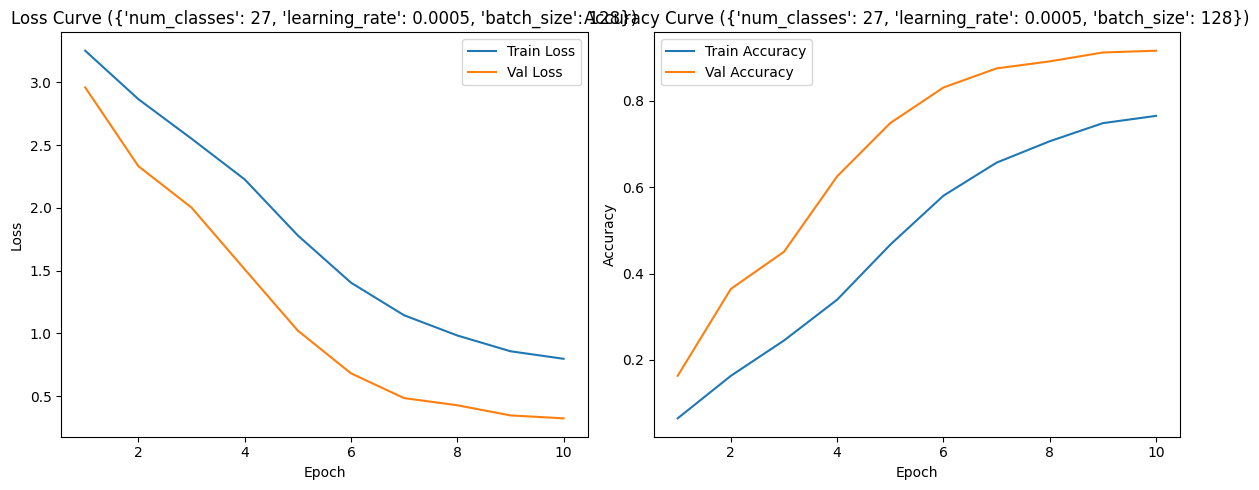

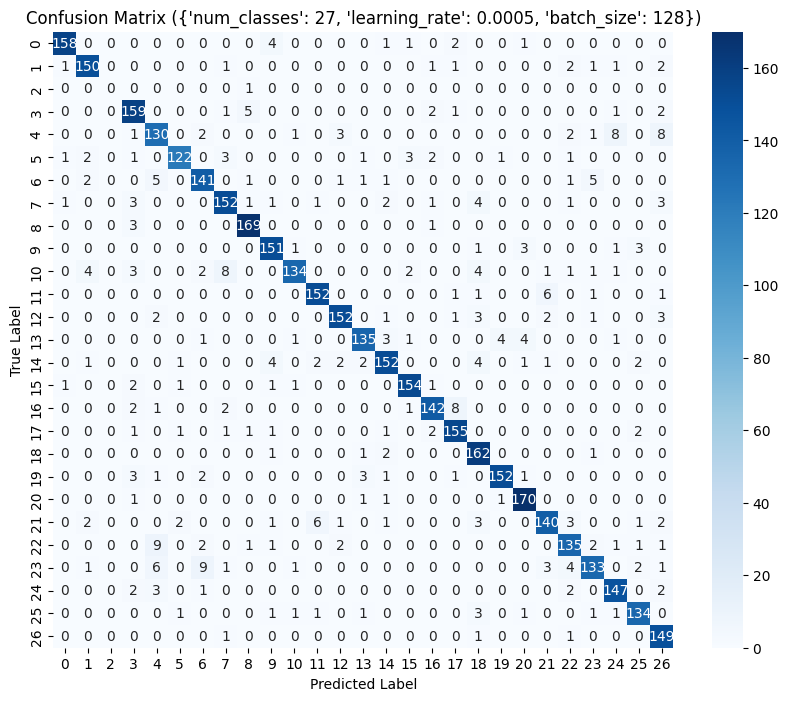

All configurations completed!
                                              config  train_loss  val_loss  \
0  {'num_classes': 27, 'learning_rate': 0.0005, '...    0.797695  0.323235   

   train_acc  val_acc  
0   0.765022  0.91583  


In [20]:
hyperparameter_configs = [
    {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 128}
]

results_df = train_and_plot_hyperparameter_effects(hyperparameter_configs, image_datasets, num_epochs=10)

print(results_df)

In [21]:
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

# Define the model (ensure it's the same architecture as your trained model)
class ASLClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(ASLClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

def load_model(model_path, num_classes=27):
    model = ASLClassifierCNN(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model


def make_predictions(model, test_loader, device, top_k=5):
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            top_probs, top_preds = torch.topk(probs, top_k, dim=1)
            
            all_preds.extend(top_preds.cpu().numpy()) 
            all_probs.extend(top_probs.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())
            
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

test_data_path = r"C:\\Users\\sgura\\Desktop\\UOFT\\Sem5\\311CSC\\Project\\main model\\Final_Data\\Train"
test_transforms = transforms.Compose([
    transforms.ToTensor(),  
])
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'C:\\Users\\sgura\\Desktop\\UOFT\\Sem5\\311CSC\\Project\\main model\\best_model_65_test_n.pth'  # Path to the trained model
model = load_model(model_path, num_classes=27).to(device)

predictions, top_probs, true_labels = make_predictions(model, test_loader, device, top_k=5)
accuracy = accuracy_score(true_labels, predictions[:, 0]) 
print(f"Test Accuracy: {accuracy:.4f}")



for i in range(5):  # Display the top 5 predictions for the first 5 examples
    print(f"True label: {test_dataset.classes[true_labels[i]]}")
    print("Top 5 Predictions:")
    for j in range(5):  # Display the top 5 predictions for this example
        print(f"  {test_dataset.classes[predictions[i][j]]}: {top_probs[i][j]:.4f}")
    print()

C:\Users\sgura\AppData\Local\Temp\ipykernel_3056\248311247.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.6456
True label: A
Top 5 Predictions:
  A: 0.4500
  Q: 0.0931
  G: 0.0781
  I: 0.0680
  J: 0.0645

True label: A
Top 5 Predictions:
  A: 0.1413
  X: 0.1141
  K: 0.1085
  N: 0.0837
  I: 0.0826

True label: A
Top 5 Predictions:
  A: 0.4332
  Q: 0.1979
  J: 0.1245
  G: 0.0718
  P: 0.0446

True label: A
Top 5 Predictions:
  A: 0.6515
  I: 0.1869
  T: 0.0315
  Y: 0.0257
  Q: 0.0177

True label: A
Top 5 Predictions:
  A: 0.3006
  Y: 0.2431
  I: 0.2395
  N: 0.0681
  R: 0.0356



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'C:\\Users\\sgura\\Desktop\\UOFT\\Sem5\\311CSC\\Project\\main model\\best_model_85_test_n.pth'
model = load_model(model_path, num_classes=27).to(device)

predictions, top_probs, true_labels = make_predictions(model, test_loader, device, top_k=5)

accuracy = accuracy_score(true_labels, predictions[:, 0])  
print(f"Test Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(true_labels, predictions[:, 0], labels=np.arange(27)) 
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1) 

class_names = test_dataset.classes  
class_accuracy = list(zip(class_names, class_accuracies))
class_accuracy_sorted = sorted(class_accuracy, key=lambda x: x[1], reverse=True)  

print("\nClass-wise Accuracy:")
for class_name, accuracy in class_accuracy_sorted:
    print(f"{class_name}: {accuracy * 100:.2f}%")


C:\Users\sgura\AppData\Local\Temp\ipykernel_3056\1827629362.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.8527

Class-wise Accuracy:
H: 98.71%
F: 97.63%
A: 95.13%
J: 94.62%
Y: 93.26%
K: 93.12%
G: 92.77%
W: 91.32%
S: 90.61%
L: 86.32%
Z: 86.08%
O: 85.39%
V: 85.29%
I: 85.20%
D: 84.69%
E: 84.10%
B: 83.87%
C: 82.89%
X: 81.68%
T: 81.42%
Q: 81.11%
P: 80.48%
R: 77.98%
U: 76.85%
N: 73.87%
M: 50.25%
Blank: 0.00%


Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 128}
Epoch 1/8
--------------------
Train Batch 1/131 - Loss: 3.2882, Accuracy: 0.0547
Train Batch 2/131 - Loss: 3.9148, Accuracy: 0.0391
Train Batch 3/131 - Loss: 3.3935, Accuracy: 0.0547
Train Batch 4/131 - Loss: 3.4591, Accuracy: 0.0234
Train Batch 5/131 - Loss: 3.3745, Accuracy: 0.0391
Train Batch 6/131 - Loss: 3.2949, Accuracy: 0.0234
Train Batch 7/131 - Loss: 3.2958, Accuracy: 0.0391
Train Batch 8/131 - Loss: 3.2871, Accuracy: 0.0312
Train Batch 9/131 - Loss: 3.2882, Accuracy: 0.0469
Train Batch 10/131 - Loss: 3.2791, Accuracy: 0.0859
Train Batch 11/131 - Loss: 3.2957, Accuracy: 0.0312
Train Batch 12/131 - Loss: 3.2912, Accuracy: 0.0391
Train Batch 13/131 - Loss: 3.2899, Accuracy: 0.0469
Train Batch 14/131 - Loss: 3.2862, Accuracy: 0.0391
Train Batch 15/131 - Loss: 3.2791, Accuracy: 0.0547
Train Batch 16/131 - Loss: 3.2899, Accuracy: 0.0625
Train Batch 17/131 - Loss: 3.2897, Accuracy: 0.0312

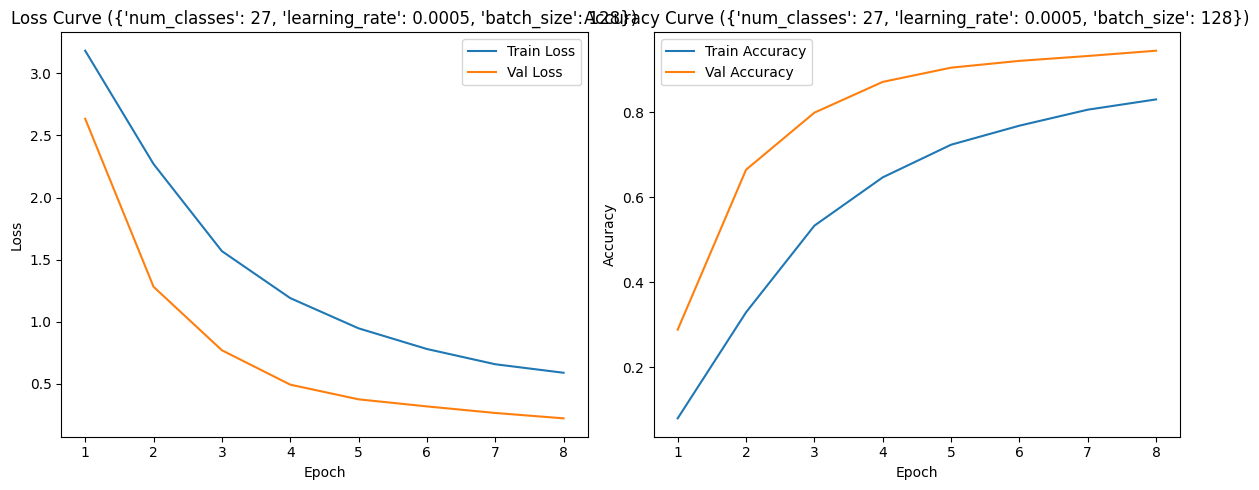

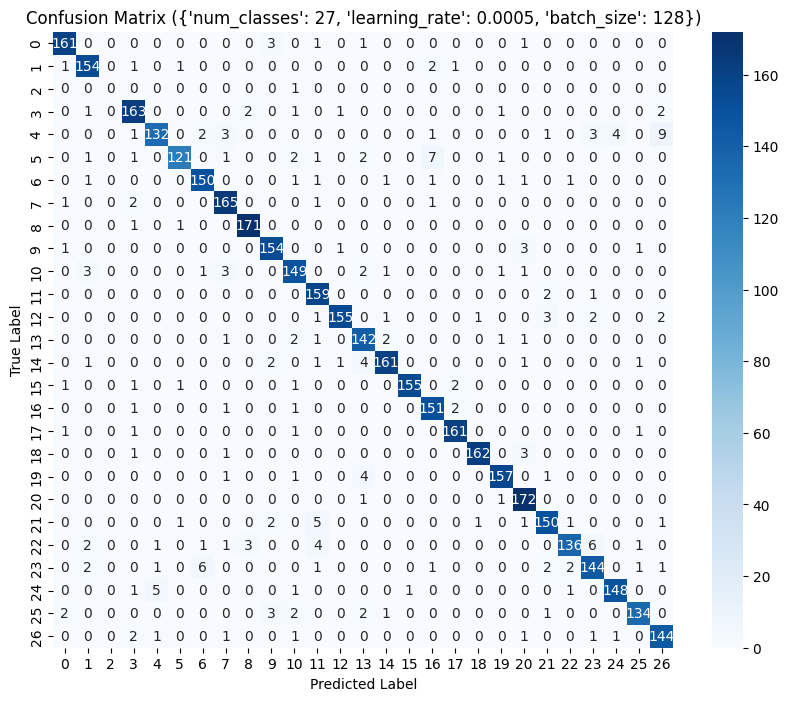

All configurations completed!
                                              config  train_loss  val_loss  \
0  {'num_classes': 27, 'learning_rate': 0.0005, '...     0.58935   0.22251   

   train_acc   val_acc  
0   0.830135  0.944763  


In [16]:
hyperparameter_configs = [
    {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 128}
]

results_df = train_and_plot_hyperparameter_effects(hyperparameter_configs, image_datasets, num_epochs=8)

print(results_df)

In [ ]:
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np


class ASLClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(ASLClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

def load_model(model_path, num_classes=27):
    model = ASLClassifierCNN(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()  
    return model


def make_predictions(model, test_loader, device, top_k=5):
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            top_probs, top_preds = torch.topk(probs, top_k, dim=1)
            
            all_preds.extend(top_preds.cpu().numpy()) 
            all_probs.extend(top_probs.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())
            
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

test_data_path = r"C:\\Users\\sgura\\Desktop\\UOFT\\Sem5\\311CSC\\Project\\main model\\Final_Data\\Train"
test_transforms = transforms.Compose([
    transforms.ToTensor(),  
])
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'C:\\Users\\sgura\\Desktop\\UOFT\\Sem5\\311CSC\\Project\\main model\\best_model.pth'  
model = load_model(model_path, num_classes=27).to(device)

predictions, top_probs, true_labels = make_predictions(model, test_loader, device, top_k=5)
accuracy = accuracy_score(true_labels, predictions[:, 0]) 
print(f"Test Accuracy: {accuracy:.4f}")

for i in range(5): 
    print(f"True label: {test_dataset.classes[true_labels[i]]}")
    print("Top 5 Predictions:")
    for j in range(5):  
        print(f"  {test_dataset.classes[predictions[i][j]]}: {top_probs[i][j]:.4f}")
    print()

C:\Users\sgura\AppData\Local\Temp\ipykernel_3056\1827629362.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.8527
True label: A
Top 5 Predictions:
  A: 0.6152
  Q: 0.1915
  J: 0.0592
  Y: 0.0461
  G: 0.0415

True label: A
Top 5 Predictions:
  I: 0.2095
  N: 0.1832
  A: 0.1725
  Y: 0.0927
  J: 0.0471

True label: A
Top 5 Predictions:
  A: 0.7511
  J: 0.0831
  Q: 0.0438
  G: 0.0288
  T: 0.0263

True label: A
Top 5 Predictions:
  A: 0.7856
  Q: 0.0813
  J: 0.0434
  T: 0.0284
  G: 0.0169

True label: A
Top 5 Predictions:
  A: 0.8888
  Y: 0.0624
  I: 0.0251
  N: 0.0129
  Q: 0.0054

